<a href="https://colab.research.google.com/github/iffigueroa/text-marketing-analytics/blob/main/dtsa_5800_network_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Analysis for Marketing Analytics

For this project, we explore Twitter data to create semantic networks for tweets relating to three popular athletic brands: Nike, Adidas, and Lululemon. The objective is to find insights about these brands by analyzing the words associated with them in tweets. By identifying top words and their frequency when each brand is mentioned, we aim to gain a deeper understanding of how these brands are perceived and discussed on social media.

The project is divided into several stages. We begin by looking at tweets from the most influential users who frequently tweet or mention Nike, Adidas, and Lululemon. Then we continue with constructing general semantic networks for each brand, focusing on identifying top words used to describe each brand generally. We then refine our analysis by categorizing tweets based on sentiment, allowing us to distinguish between positive and negative discussions. This approach enables us to uncover both the positive aspects that resonate with consumers and the negative issues that may need attention from the brands.


## A quick look at the data


In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/3_network_analysis/1FinalReport"
JSON_LOC = f'{path}/nikelululemonadidas_tweets.jsonl'
SHOW_PNGS_FOR_GIT = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# A quick loop through to see how many tweets we have to work with and what the structure of one is.
import json
sample_tweet = None
with open(JSON_LOC) as file:
  for i, line in enumerate(file):
      if i == 0:
        sample_tweet = json.loads(line)


print(f"Dataset contains data for {i} tweets.")

Dataset contains data for 175077 tweets.


In [3]:
sample_tweet

{'created_at': 'Fri Oct 01 08:25:03 +0000 2021',
 'id': 1443854459625431000,
 'id_str': '1443854459625431041',
 'full_text': "#ad The Nike Women's Air More Uptempo 96 'White/Opti Yellow' is now available via @footlocker! |$160| #SneakerScouts @Nike https://t.co/5lAq7b2ffU https://t.co/wmjxIcsheP",
 'truncated': False,
 'display_text_range': [0, 146],
 'entities': {'hashtags': [{'text': 'ad', 'indices': [0, 3]},
   {'text': 'SneakerScouts', 'indices': [102, 116]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'footlocker',
    'name': 'Foot Locker',
    'id': 22030851,
    'id_str': '22030851',
    'indices': [82, 93]},
   {'screen_name': 'Nike',
    'name': 'Nike',
    'id': 415859364,
    'id_str': '415859364',
    'indices': [117, 122]}],
  'urls': [{'url': 'https://t.co/5lAq7b2ffU',
    'expanded_url': 'https://www.footlocker.com/product/~/D3035100.html?irclickid=R9hRvy2vcxyLWQd07OwzdzZ-UkBTPTz1QxOkxU0&sid=8259&cm_mmc=Affiliate-_-SneakerScouts-_--_-Content-_--_--_-p-_--_--_-

From the above, we can see that there are over 175K tweets to work with, and each has quite a bit of metadata associated with it. Obviously we can't load all of this into memory, and we wouldn't want to - most of it isn't relevant to our analysis. So we'll pick out the important bits to proceed with.

### Extracting Relevant Data

In [4]:
def tweet_handler(handler, top_users_filter = None):
  """ Helper so i don't have to keep calling the same base code :) """
  with open(JSON_LOC) as file:
      for i, line in enumerate(file):
          if i % 10000 == 0:
              print(f"Processed {i} tweets")
          tweet_data = json.loads(line)
          if not top_users_filter or tweet_data['user']['id'] in top_users_filter:
                handler(tweet_data)

In [5]:
MAIN_ACCOUNTS = ['Nike', 'adidas', 'lululemon']

In [6]:
users = {}


def build_user_dict(tweet):
  user = tweet['user']
  id = user['id']
  if id not in users:
    users[id] = {
        'screen_name': user['screen_name'],
        'tweet_count': 0,
        'mentions': 0,
    }
    # Add Mentioned users:
    for mention in tweet["entities"]["user_mentions"]:
      if mention['screen_name'] in MAIN_ACCOUNTS:
        if mention['id'] not in users:
          users[mention['id']] = {
            'screen_name': mention['screen_name'],
            'tweet_count': 0,
            'mentions': 0,
            'followers': -1
          }
        users[mention['id']]['mentions'] += 1
  users[id]['followers'] = user['followers_count']
  users[id]['tweet_count'] += 1

tweet_handler(handler = build_user_dict)

Processed 0 tweets
Processed 10000 tweets
Processed 20000 tweets
Processed 30000 tweets
Processed 40000 tweets
Processed 50000 tweets
Processed 60000 tweets
Processed 70000 tweets
Processed 80000 tweets
Processed 90000 tweets
Processed 100000 tweets
Processed 110000 tweets
Processed 120000 tweets
Processed 130000 tweets
Processed 140000 tweets
Processed 150000 tweets
Processed 160000 tweets
Processed 170000 tweets


#### About the Users

In [7]:
import pandas as pd
user_df = pd.DataFrame.from_dict(users, orient='index')
user_df.head()

,screen_name,tweet_count,mentions,followers
792182745942233100,SneakerScouts,7118,0,18262
415859364,Nike,0,65621,-1
723347581586255900,NateRuns5,3,0,117
300114634,adidas,3,26592,4082910
25992197,paulitar,1,0,23


In [8]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104774 entries, 792182745942233100 to 1273861910
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   screen_name  104774 non-null  object
 1   tweet_count  104774 non-null  int64 
 2   mentions     104774 non-null  int64 
 3   followers    104774 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.0+ MB


In [9]:
print(f"There are {user_df.shape[0]} unique users in this dataset.")

There are 104774 unique users in this dataset.


In [10]:
user_df['tweet_count'].describe()

count    104774.000000
mean          1.671006
std          26.730194
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        7118.000000
Name: tweet_count, dtype: float64

In [11]:
user_df['followers'].describe()

count    1.047740e+05
mean     6.091621e+03
std      2.267507e+05
min     -1.000000e+00
25%      1.130000e+02
50%      3.620000e+02
75%      1.052000e+03
max      5.061493e+07
Name: followers, dtype: float64

In [12]:
user_df['mentions'].describe()

count    104774.000000
mean          0.921011
std         219.141696
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       65621.000000
Name: mentions, dtype: float64

In [13]:
top_users = []

for id, user in users.items():
  if (user['tweet_count'] > 2 and user['followers'] > 100000) or (user['screen_name'] in MAIN_ACCOUNTS):
    top_users.append(id)

In [14]:
top_users_df = user_df[user_df.index.isin(top_users)]

In [15]:
print(f"There are {top_users_df.shape[0]} unique users in this dataset.")

There are 102 unique users in this dataset.


In [16]:
top_users_df['tweet_count'].describe()

count    102.00000
mean       7.00000
std        7.36193
min        0.00000
25%        3.00000
50%        4.00000
75%        7.00000
max       42.00000
Name: tweet_count, dtype: float64

In [17]:
top_users_df['followers'].describe()

count    1.020000e+02
mean     9.058997e+05
std      1.981844e+06
min     -1.000000e+00
25%      1.430755e+05
50%      3.167740e+05
75%      9.423368e+05
max      1.739171e+07
Name: followers, dtype: float64

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(data, name):
  plt.figure(figsize=(10, 6))
  sns.histplot(data[name], kde=True)
  name = name.replace("_", " ").title()
  plt.xlabel(name)
  plt.ylabel('Frequency')
  plt.title(f'Distribution of {name}')
  plt.grid(alpha = 0.25)
  plt.show()

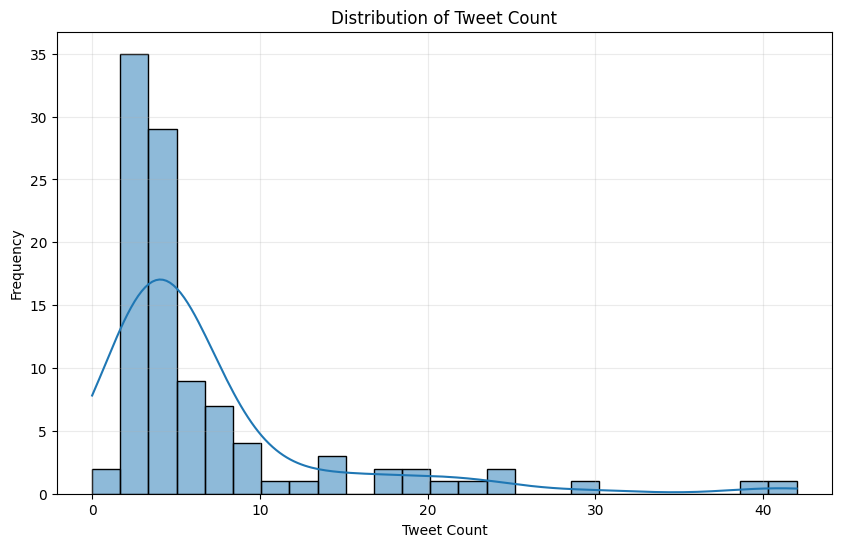

In [19]:
make_plot(top_users_df, 'tweet_count')

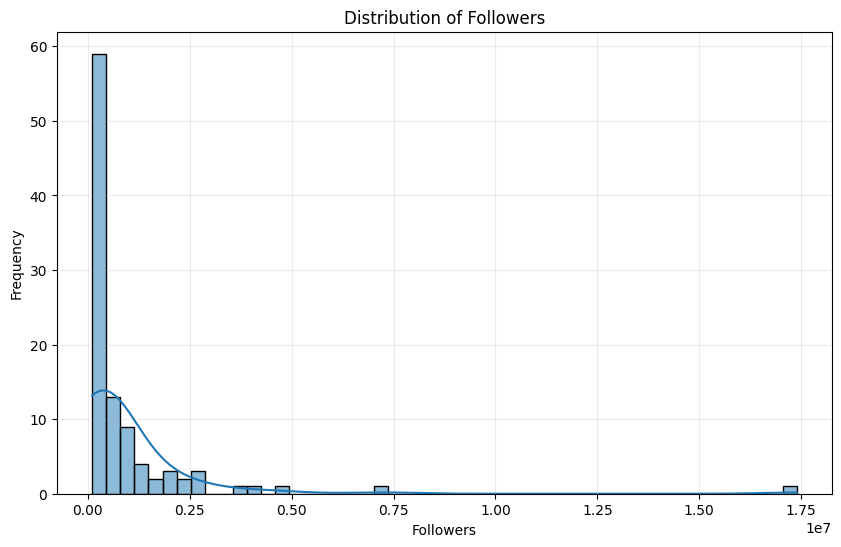

In [20]:
top_users_with_followers = top_users_df[top_users_df['followers'] != -1]

make_plot(top_users_with_followers, 'followers')

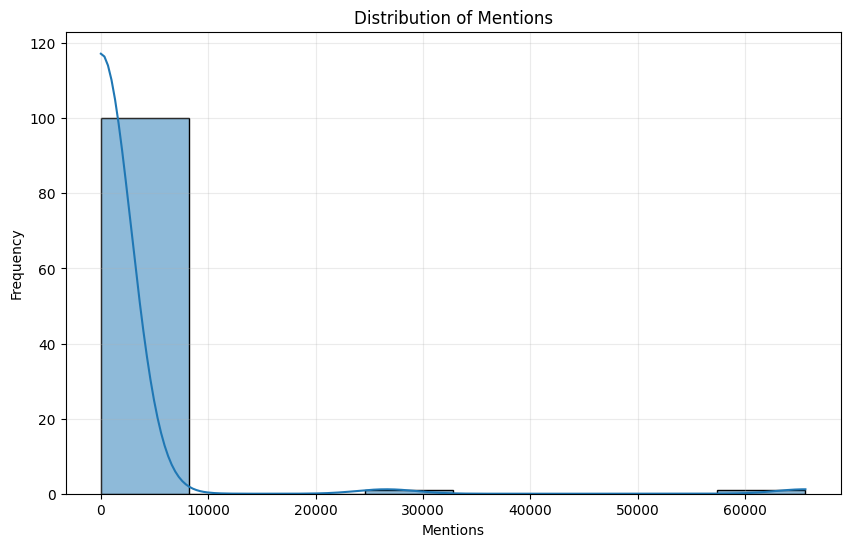

In [21]:
make_plot(top_users_df, 'mentions')

In [22]:
nike_adidas_lululemon = top_users_df[top_users_df['screen_name'].isin(MAIN_ACCOUNTS)]
nike_adidas_lululemon.head()

,screen_name,tweet_count,mentions,followers
415859364,Nike,0,65621,-1
300114634,adidas,3,26592,4082910
16252784,lululemon,0,4285,-1


## Twitter Mentions Graph

In [23]:
try:
  import pyvis
except ModuleNotFoundError:
  !pip install pyvis

In [24]:
from pyvis.network import Network
from IPython.core.display import display, HTML, Image

#Graph Helpers
def print_graph_info(graph):
  print(f"{graph.num_edges()} edges in graph.")
  print(f"{graph.num_nodes()} nodes in graph.")

def display_graph(graph, png_name):
    print_graph_info(graph)
    if graph.num_nodes() > 0 and graph.num_edges() > 0:
      if SHOW_PNGS_FOR_GIT:
        display(Image(filename=f'{path}/{png_name}.png') )
      else:
        graph.show(f"{png_name}.html")
        display(HTML(f"{png_name}.png"))


def init_graph(directed: bool = False):
    nt = Network(
                directed = directed,
                notebook=True,
                cdn_resources="remote"
              )
    nt.repulsion()
    return nt

In [25]:
mention_nt = init_graph(directed=True)


def mention_handler(tweet):
  user = tweet['user']
  if user["id"] in top_users:
      for mention in tweet["entities"]["user_mentions"]:
          if mention["id"] in top_users:
            if mention["screen_name"] in MAIN_ACCOUNTS:
              mention_nt.add_node(mention["screen_name"], color="pink")
            else:
              mention_nt.add_node(mention["screen_name"])
            mention_nt.add_node(user["screen_name"])
            mention_nt.add_edge(user["screen_name"], mention["screen_name"])
tweet_handler(handler = mention_handler)

Processed 0 tweets
Processed 10000 tweets
Processed 20000 tweets
Processed 30000 tweets
Processed 40000 tweets
Processed 50000 tweets
Processed 60000 tweets
Processed 70000 tweets
Processed 80000 tweets
Processed 90000 tweets
Processed 100000 tweets
Processed 110000 tweets
Processed 120000 tweets
Processed 130000 tweets
Processed 140000 tweets
Processed 150000 tweets
Processed 160000 tweets
Processed 170000 tweets


863 edges in graph.
101 nodes in graph.


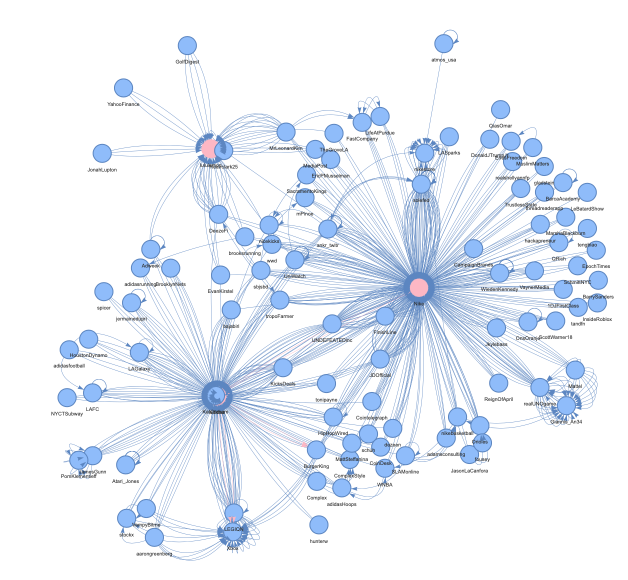

In [26]:
display_graph(mention_nt, 'all_user_mentions')

#### Who are the most central users?

One question that the above data may help us answer is which users are most central to each of the three brands we are exploring, that is who are the ones mentioning the brand the most? We can use the code in this next section to help figure that out.

We'll start by obtaining which users are directly mentioning the brands, as the previous graph has a few who are not directly tweeting, but are adjacent or also have many mentions. Once we've found that out we can see how many mentions each user has for each brand, and how many total mentions for the three brands they have.

In [27]:
# Lets see who interacted with each of Nike/Adidas/Lululemon most
from collections import defaultdict

mentions = defaultdict(lambda: defaultdict(int))
for edge in mention_nt.edges:
  source, dest = edge['from'], edge['to']
  if dest in MAIN_ACCOUNTS:
    mentions[source][dest]+=1

mentions_df = pd.DataFrame.from_dict(mentions, orient='index')
mentions_df.fillna(0, inplace=True)
mentions_df['Total'] = mentions_df.sum(axis=1)
print(f"There are {mentions_df.shape[0]} users who directly mentioned Nike/Adidas/Lululemon in this dataset.")

There are 98 users who directly mentioned Nike/Adidas/Lululemon in this dataset.


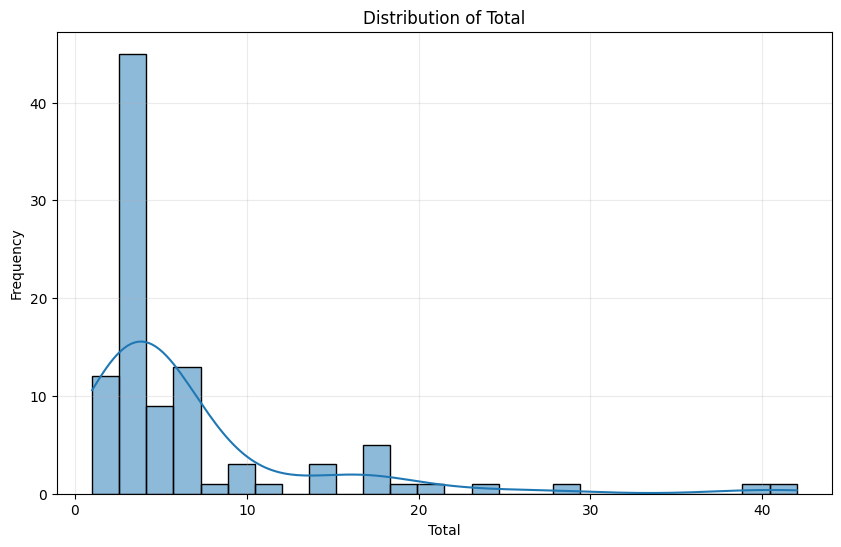

In [28]:
mentions_df_sorted = mentions_df.sort_values(by='Total', ascending=False)
make_plot(mentions_df_sorted, 'Total')

In the above plot, we can see that most people do not have more than 5 total mentions between the three brands. We'd expect the more influential/central users to have more total mentions. Below we can see the users with the most mentions. Note that not all of them are mentioning all three brands but some are, we'll take a closer look at that later.

In [29]:
mentions_df_sorted.head(10)

,adidas,Nike,lululemon,Total
UNDEFEATEDinc,13.0,29.0,0.0,42.0
solefed,0.0,39.0,0.0,39.0
KicksDeals,19.0,9.0,0.0,28.0
JDOfficial,4.0,20.0,0.0,24.0
LEGIQN,21.0,0.0,0.0,21.0
FinishLine,3.0,16.0,0.0,19.0
snkr_twitr,4.0,13.0,0.0,17.0
DeezeFi,1.0,2.0,14.0,17.0
MrLeonardKim,0.0,3.0,14.0,17.0
KatGraham,17.0,0.0,0.0,17.0


The proceeding 3 cells help us get an idea of the most influential/central users by brand:

In [30]:
nike_mentions = mentions_df[mentions_df["Nike"] > 0].sort_values(by='Nike', ascending=False)
print("Top Nike Mentioners")
nike_mentions.head(10)

Top Nike Mentioners


,adidas,Nike,lululemon,Total
solefed,0.0,39.0,0.0,39.0
UNDEFEATEDinc,13.0,29.0,0.0,42.0
JDOfficial,4.0,20.0,0.0,24.0
FinishLine,3.0,16.0,0.0,19.0
realUNOgame,0.0,15.0,0.0,15.0
snkr_twitr,4.0,13.0,0.0,17.0
tropoFarmer,6.0,11.0,0.0,17.0
UniWatch,3.0,11.0,1.0,15.0
WiedenKennedy,0.0,10.0,0.0,10.0
KicksDeals,19.0,9.0,0.0,28.0


In [31]:
adidas_mentions = mentions_df[mentions_df["adidas"] > 0].sort_values(by='adidas', ascending=False)
print("Top Adidas Mentioners")
adidas_mentions.head(10)

Top Adidas Mentioners


,adidas,Nike,lululemon,Total
LEGIQN,21.0,0.0,0.0,21.0
KicksDeals,19.0,9.0,0.0,28.0
KatGraham,17.0,0.0,0.0,17.0
UNDEFEATEDinc,13.0,29.0,0.0,42.0
LAGalaxy,12.0,0.0,0.0,12.0
bajabiri,9.0,1.0,0.0,10.0
LAFC,7.0,0.0,0.0,7.0
JamesGunn,7.0,0.0,0.0,7.0
HipHopWired,6.0,8.0,0.0,14.0
jermainedupri,6.0,0.0,0.0,6.0


In [32]:
lululemon_mentions = mentions_df[mentions_df["lululemon"] > 0].sort_values(by='lululemon', ascending=False)
print("Top Lululemon Mentioners")
lululemon_mentions.head(10)

Top Lululemon Mentioners


,adidas,Nike,lululemon,Total
DeezeFi,1.0,2.0,14.0,17.0
MrLeonardKim,0.0,3.0,14.0,17.0
Realrclark25,0.0,1.0,5.0,6.0
GolfDigest,0.0,0.0,4.0,4.0
EvanKirstel,0.0,1.0,3.0,4.0
MediaPost,0.0,2.0,3.0,5.0
JonahLupton,0.0,0.0,3.0,3.0
YahooFinance,0.0,0.0,3.0,3.0
Adweek,3.0,0.0,2.0,5.0
brooksrunning,0.0,2.0,2.0,4.0


#### Who are the most important bridgers?

The most influential bridgers are people who are mentioning multiple brands. In the plot below, we can see that UniWatch, DeezeFi, and wwd are the most influential bridges as they are mentioning all 3 brands. You can also likely include UNDEFEATEDinc because they have a lot more tweets overall, even if they are only mentioning two of the three brands.

In [33]:
def count_nonzero(row):
  # sum how many cols are non-zero (subtract 1 so we don't count total)
    return sum(row.iloc[:-2] != 0)

mentions_df['Brands Mentioned'] = mentions_df.apply(count_nonzero, axis=1)
brands_mentioned = mentions_df.sort_values(by='Brands Mentioned', ascending=False)
brands_mentioned.head(10)

,adidas,Nike,lululemon,Total,Brands Mentioned
UNDEFEATEDinc,13.0,29.0,0.0,42.0,2
SLAMonline,1.0,3.0,0.0,4.0,2
UniWatch,3.0,11.0,1.0,15.0,2
adidas,1.0,2.0,0.0,3.0,2
BurgerKing,3.0,4.0,0.0,7.0,2
tonipayne,3.0,4.0,0.0,7.0,2
MattSteffanina,2.0,1.0,0.0,3.0,2
tropoFarmer,6.0,11.0,0.0,17.0,2
ComplexStyle,3.0,2.0,0.0,5.0,2
nicekicks,1.0,2.0,0.0,3.0,2


To help visualize the above results, I created another network. For users that mention more brands, the shade of their Nodes is darker.

In [34]:
# See if there are any people mentioning one or more frequently
nt_mentions_by_brand = init_graph()
shade = {
  1: '#3895D3',
  2: '#1261A0',
  3: '#072F5F'
}

for mentioner in mentions:
  n = len(mentions[mentioner])
  for brand in mentions[mentioner]:
    nt_mentions_by_brand.add_node(brand)
    nt_mentions_by_brand.add_node(mentioner, color=shade[n])
    nt_mentions_by_brand.add_edge(mentioner, brand)


132 edges in graph.
100 nodes in graph.


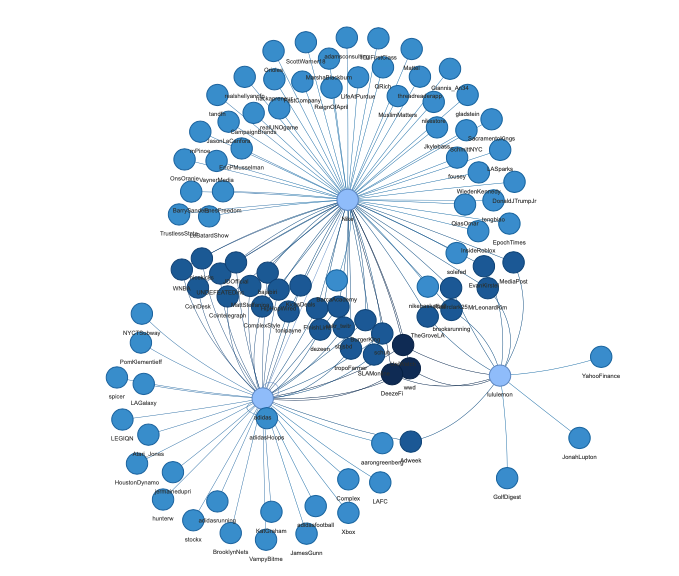

In [35]:
display_graph(nt_mentions_by_brand, "mentions_by_brand")

## Semantic Network Graph

Now that we've taken a look at interactions between users and the big brands, we can now take a look at the actual tweets. In this section I'll be building a semantic network graph based on the top words found across tweets from our top influencers.

To start we'll take a look at how all of the top words relate to Nike/Adidas/Lululemon, then we'll take a closer look by sentiment. I'll create two more graphs to analyze the top words, the first will be words from top tweets with positive sentiments, and top tweets from negative sentiments.

As always, before taking a look at the tweets I'll be performing some preprocessing to make it easier to build the graph. For each tweet the preprocessing will include:

- Text case noramlization
- Tokenization - using nltk TweetTokenizer
- Removal of hyperlinks
- removal of stopwords
- removal of puncutation
- removal of words shorter than 2 characters
- lematization




In [36]:
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
import itertools
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
def compare_top_words(graph):
  """Helper to see what words are common across nike/adidas/lululemon"""
  common_words = {}
  nodes = nt_words.get_adj_list()
  for node in nodes:
    adj = nodes[node]
    common_words[node] = {
        key: 1 for key in ['nike', 'lululemon', 'adidas'] if key in adj
    }
  df = pd.DataFrame.from_dict(common_words, orient='index')
  df.fillna(0, inplace=True)
  df['Total'] = df.sum(axis=1)

  return df.sort_values(by='Total', ascending=False)

def visualize_overlapping_words(graph, name):
  cmp_df = compare_top_words(graph)
  words_by_brand = init_graph()
  shade = {
    1: '#3895D3',
    2: '#1261A0',
    3: '#072F5F'
  }

  for index, row in cmp_df.iterrows():
    n = int(row['Total'])
    for brand in row.index[:-1]:  # Exclude the totals column
      if row[brand] != 0:
        words_by_brand.add_node(brand, color = 'pink')
        words_by_brand.add_node(index, color=shade[n])
        words_by_brand.add_edge(index, brand)


  display_graph(words_by_brand, name)
  return cmp_df

In [38]:
def remove_links(tokens):
  return [token for token in tokens if (not token.startswith("http://") and not token.startswith("https://"))]

def remove_stopwords(tokens, stopwords=None):
    if stopwords is None:
        stopwords = nltk.corpus.stopwords.words("english")
    return [ token for token in tokens if token not in stopwords ]

def remove_punctuation(tokens):
  return [t.replace('@', '').replace('#', '') for t in tokens if t not in string.punctuation]

def stem(tokens):
    return [ nltk.PorterStemmer().stem(token) for token in tokens ]

def remove_short_words(tokens):
  return [t for t in tokens if len(t)>2]

def lemmatize(tokens):
    lemmas = []
    for token in tokens:
        if isinstance(token, str):
            lemmas.append(nltk.WordNetLemmatizer().lemmatize(token)) # treats token like a noun
        else:
            lemmas.append(nltk.WordNetLemmatizer().lemmatize(*token))
    return lemmas


stopwords = nltk.corpus.stopwords.words("english")
stopwords.append('rt')
stopwords.append('…')
stopwords.append('’')

def preprocess(tweet):
  tweet = tweet.lower()
  tokens = nltk.TweetTokenizer().tokenize(tweet)
  tokens = remove_links(tokens)
  tokens = remove_stopwords(tokens, stopwords=stopwords)
  tokens = remove_punctuation(tokens)
  tokens = lemmatize(tokens)
  tokens = remove_short_words(tokens)
  return tokens

### Identify Top Words Across Tweets

In [39]:
all_words = {}

def find_all_words(tweet):
  tokens = preprocess(tweet['full_text'])
  for t in tokens:
      if t not in all_words:
          all_words[t] = 0
      all_words[t] += 1
tweet_handler(handler = find_all_words, top_users_filter = top_users)


Processed 0 tweets
Processed 10000 tweets
Processed 20000 tweets
Processed 30000 tweets
Processed 40000 tweets
Processed 50000 tweets
Processed 60000 tweets
Processed 70000 tweets
Processed 80000 tweets
Processed 90000 tweets
Processed 100000 tweets
Processed 110000 tweets
Processed 120000 tweets
Processed 130000 tweets
Processed 140000 tweets
Processed 150000 tweets
Processed 160000 tweets
Processed 170000 tweets


In [40]:
total = sum(all_words.values())
print(total)
print(len(all_words))

7441
2757


In [41]:
sorted_counts = sorted(all_words.items(), key=lambda item: item[1], reverse=True)
sorted_words = [word for word, count in sorted_counts]
print(sorted_words[:20])

['nike', 'adidas', 'lululemon', 'available', 'xbox', 'jumpman23', 'solefed', 'day', 'air', 'new', 'get', 'solesavy', 'game', 'year', 'one', 'brand', 'online', 'low', 'giannis_an34', 'got']


In [42]:
print("Nike:", all_words["nike"])
print("Adidas:", all_words["adidas"])
print("Lululemon:", all_words["lululemon"])

Nike: 451
Adidas: 240
Lululemon: 59


In [43]:
N = 50
top_terms = sorted_words[:N]

nt_words = init_graph()
nike_words = init_graph()
adidas_words = init_graph()
lululemon_words = init_graph()

words_map = {
    'adidas': adidas_words,
    'nike': nike_words,
    'lululemon': lululemon_words,
}


def process_common_words_by_brand(tweet):
  tokens = preprocess(tweet['full_text'])
  nodes = [t for t in tokens if t in top_terms]
  for n in nodes:
    if n in ['nike', 'adidas', 'lululemon']:
      nt_words.add_node(n, color = 'pink')
    else:
      nt_words.add_node(n)
  cooccurrences = itertools.combinations(nodes, 2)
  for c in cooccurrences:
    if c[0] != c[1]:
      if c not in nt_words.edges:
        nt_words.add_edge(c[0], c[1])
      for key in words_map.keys():
        if key in c:
          node = c[0] if c[0]!=key else c[1]
          words_map[key].add_node(key, color='pink')
          words_map[key].add_node(node)
          words_map[key].add_edge(node, key)
          break



tweet_handler(handler = process_common_words_by_brand, top_users_filter = top_users)


Processed 0 tweets
Processed 10000 tweets
Processed 20000 tweets
Processed 30000 tweets
Processed 40000 tweets
Processed 50000 tweets
Processed 60000 tweets
Processed 70000 tweets
Processed 80000 tweets
Processed 90000 tweets
Processed 100000 tweets
Processed 110000 tweets
Processed 120000 tweets
Processed 130000 tweets
Processed 140000 tweets
Processed 150000 tweets
Processed 160000 tweets
Processed 170000 tweets


103 edges in graph.
50 nodes in graph.


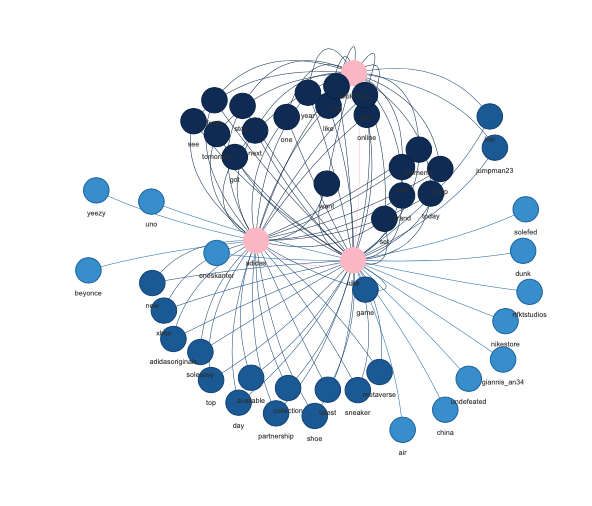

,nike,adidas,lululemon,Total
online,1.0,1.0,1.0,3.0
tomorrow,1.0,1.0,1.0,3.0
shop,1.0,1.0,1.0,3.0
one,1.0,1.0,1.0,3.0
pair,1.0,1.0,1.0,3.0
brand,1.0,1.0,1.0,3.0
like,1.0,1.0,1.0,3.0
year,1.0,1.0,1.0,3.0
want,1.0,1.0,1.0,3.0
get,1.0,1.0,1.0,3.0


In [44]:
visualize_overlapping_words(nt_words, 'common_words_full')

46 edges in graph.
47 nodes in graph.


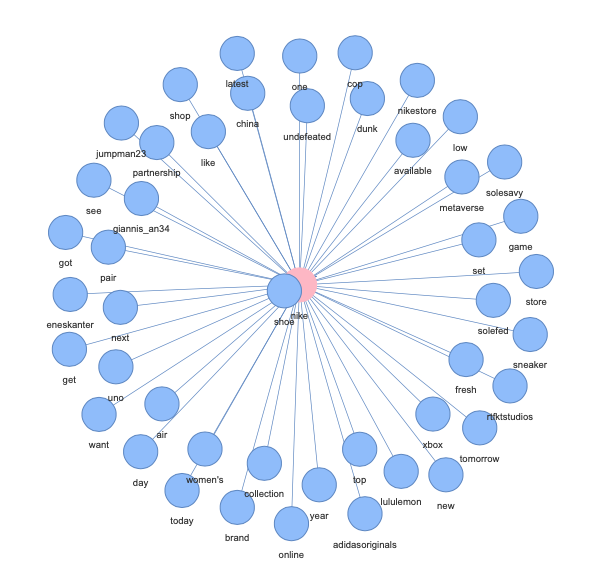

In [45]:
display_graph(nike_words, "common_words_nike")

36 edges in graph.
37 nodes in graph.


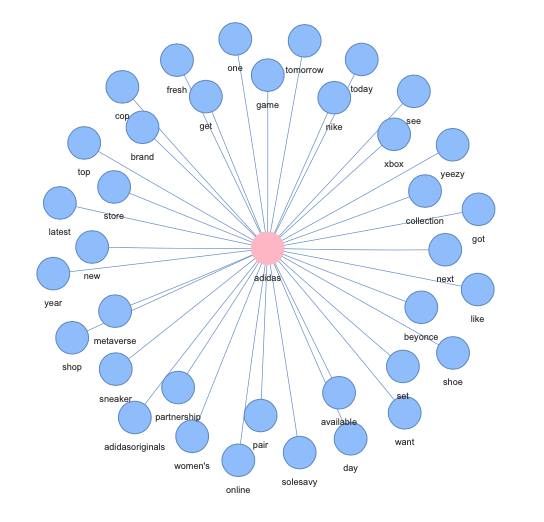

In [46]:
display_graph(adidas_words, "common_words_adidas")

21 edges in graph.
22 nodes in graph.


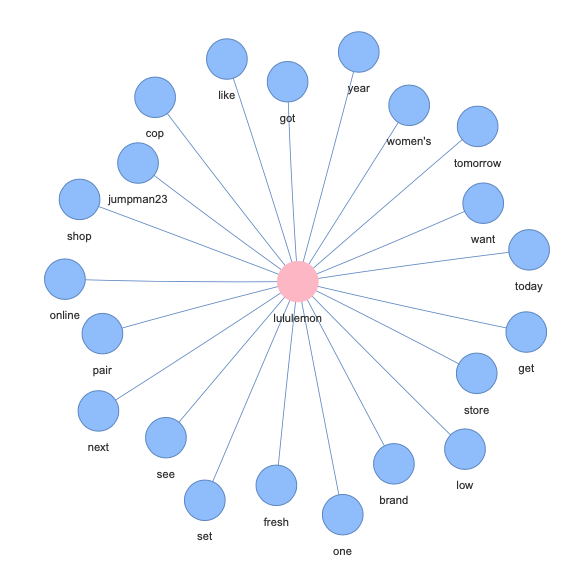

In [47]:
display_graph(lululemon_words, 'common_words_lululemon')

## Sentiment Segmentation

In [48]:

from textblob import TextBlob

def check_sentiment(text):
    blob = TextBlob(text)
    polarity, subjectivity = blob.sentiment
    if polarity > 0.25:
      return 1
    elif polarity < -0.25:
      return -1
    return 0

positive_words = {}
negative_words = {}

sentiment_map = {
    1: positive_words,
    -1: negative_words,
}
def find_words_with_sentiment(tweet):
  sentiment = check_sentiment(tweet['full_text'])
  tokens = preprocess(tweet['full_text'])
  if sentiment != 0:
    word_dict = sentiment_map[sentiment]
    for t in tokens:
        if t not in word_dict:
            word_dict[t] = 0
        word_dict[t] += 1

tweet_handler(handler = find_words_with_sentiment, top_users_filter = top_users)


def get_words_by_count(word_dict):
  print(len(word_dict))
  print(sum(word_dict.values()))
  sorted_counts = sorted(word_dict.items(), key=lambda item: item[1], reverse=True)
  sorted_words = [word for word, count in sorted_counts]
  print(sorted_words[:20])
  return sorted_words

print("Positive")
sorted_positive_words = get_words_by_count(positive_words)
print("Negative")
sorted_negative_words = get_words_by_count(negative_words)

Processed 0 tweets
Processed 10000 tweets
Processed 20000 tweets
Processed 30000 tweets
Processed 40000 tweets
Processed 50000 tweets
Processed 60000 tweets
Processed 70000 tweets
Processed 80000 tweets
Processed 90000 tweets
Processed 100000 tweets
Processed 110000 tweets
Processed 120000 tweets
Processed 130000 tweets
Processed 140000 tweets
Processed 150000 tweets
Processed 160000 tweets
Processed 170000 tweets
Positive
1171
2332
['nike', 'adidas', 'available', 'xbox', 'day', 'air', 'one', 'latest', 'lululemon', 'good', 'favorite', 'year', 'get', 'partnership', 'win', 'love', 'shoe', 'yeezy', 'welcome', 'online']
Negative
227
334
['nike', 'adidas', 'game', 'xbox', 'impossibleisnothing', 'crazy', 'chance', 'uno', 'giannis_an34', 'coming', 'grower', 'today', 'unlvfootball', '.\n.\n.', 'usnikefootball', 'uniswag', 'policy', 'goal', 'slave', 'labor']


#### Words from positive Tweets

In [49]:
N = 50
top_terms = sorted_positive_words[:N]

nt_words = init_graph()
nike_words = init_graph()
adidas_words = init_graph()
lululemon_words = init_graph()

words_map = {
    'adidas': adidas_words,
    'nike': nike_words,
    'lululemon': lululemon_words,
}


tweet_handler(handler = process_common_words_by_brand, top_users_filter = top_users)


Processed 0 tweets
Processed 10000 tweets
Processed 20000 tweets
Processed 30000 tweets
Processed 40000 tweets
Processed 50000 tweets
Processed 60000 tweets
Processed 70000 tweets
Processed 80000 tweets
Processed 90000 tweets
Processed 100000 tweets
Processed 110000 tweets
Processed 120000 tweets
Processed 130000 tweets
Processed 140000 tweets
Processed 150000 tweets
Processed 160000 tweets
Processed 170000 tweets


100 edges in graph.
50 nodes in graph.


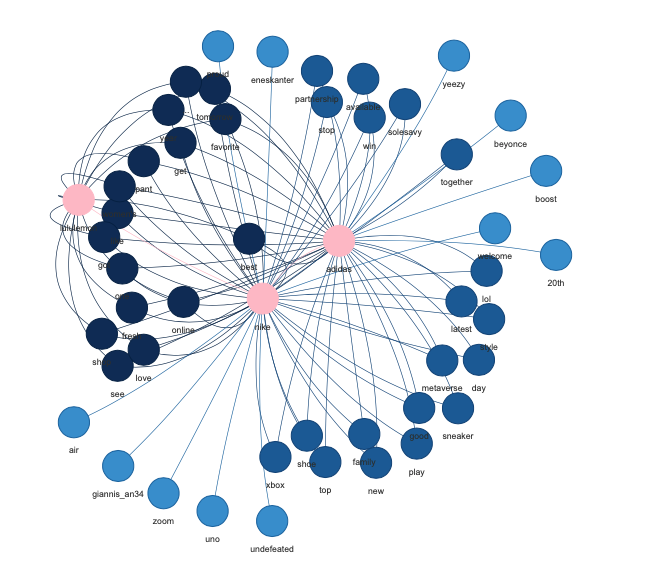

,nike,lululemon,adidas,Total
favorite,1.0,1.0,1.0,3.0
see,1.0,1.0,1.0,3.0
fresh,1.0,1.0,1.0,3.0
shop,1.0,1.0,1.0,3.0
year,1.0,1.0,1.0,3.0
one,1.0,1.0,1.0,3.0
love,1.0,1.0,1.0,3.0
get,1.0,1.0,1.0,3.0
tomorrow,1.0,1.0,1.0,3.0
like,1.0,1.0,1.0,3.0


In [50]:
visualize_overlapping_words(nt_words, "common_words_positive_full")

44 edges in graph.
45 nodes in graph.


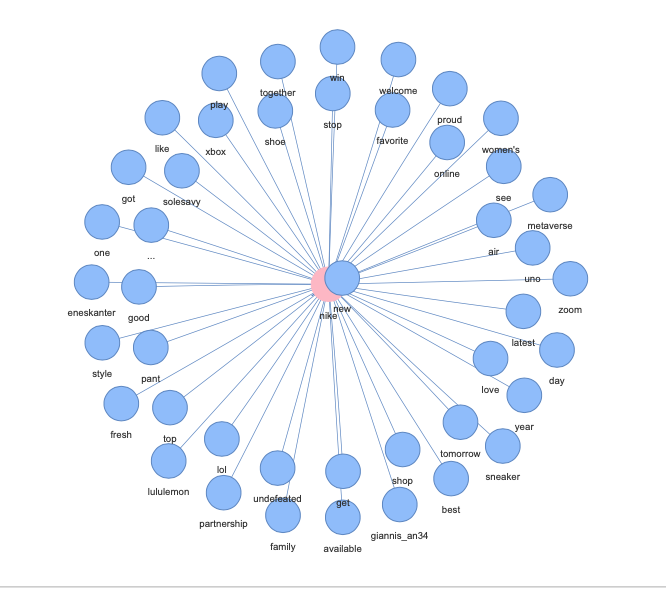

In [51]:
display_graph(nike_words, "common_words_positive_nike")

40 edges in graph.
41 nodes in graph.


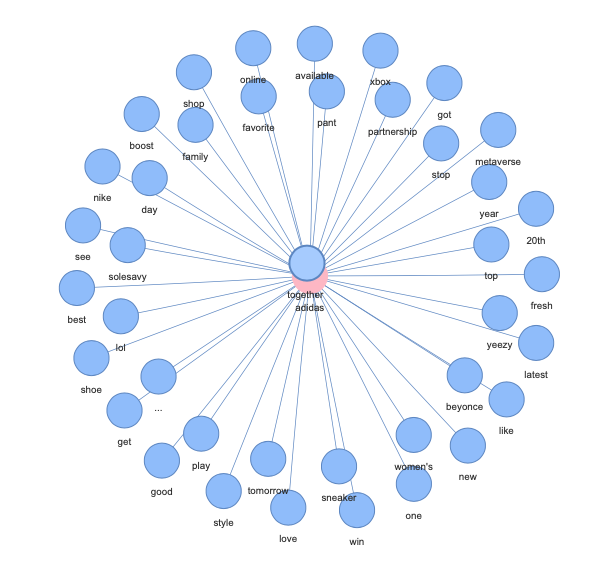

In [52]:
display_graph(adidas_words, "common_words_positive_adidas")


16 edges in graph.
17 nodes in graph.


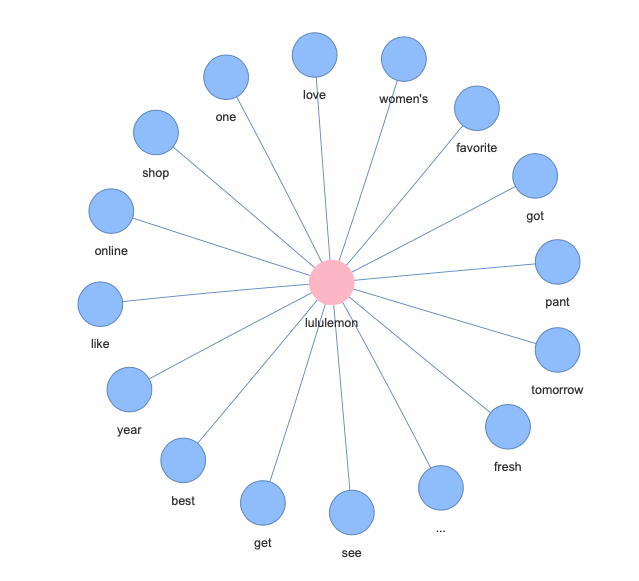

In [53]:
display_graph(lululemon_words, "common_words_positive_lululemon")

#### Words from Negative Tweets

In [54]:
N = 50
top_terms = sorted_negative_words[:N]

nt_words = init_graph()
nike_words = init_graph()
adidas_words = init_graph()
lululemon_words = init_graph()

words_map = {
    'adidas': adidas_words,
    'nike': nike_words,
    'lululemon': lululemon_words,
}


tweet_handler(handler = process_common_words_by_brand, top_users_filter = top_users)

print(nt_words.num_edges())
print(nt_words.num_nodes())

Processed 0 tweets
Processed 10000 tweets
Processed 20000 tweets
Processed 30000 tweets
Processed 40000 tweets
Processed 50000 tweets
Processed 60000 tweets
Processed 70000 tweets
Processed 80000 tweets
Processed 90000 tweets
Processed 100000 tweets
Processed 110000 tweets
Processed 120000 tweets
Processed 130000 tweets
Processed 140000 tweets
Processed 150000 tweets
Processed 160000 tweets
Processed 170000 tweets
266
50


67 edges in graph.
50 nodes in graph.


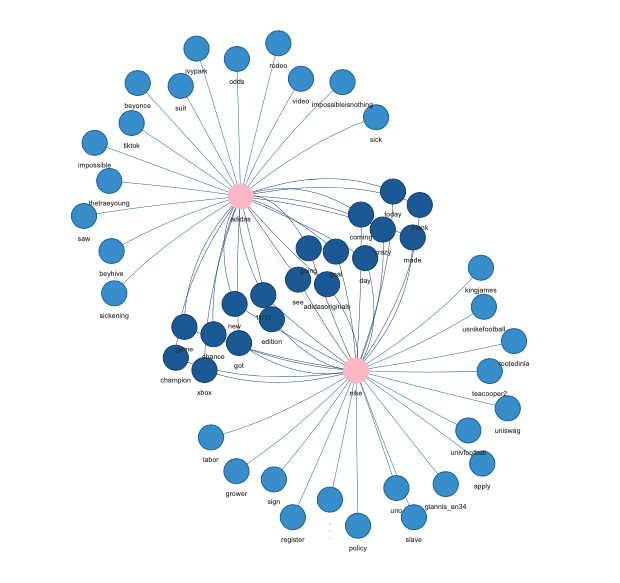

,nike,adidas,Total
new,1.0,1.0,2.0
coming,1.0,1.0,2.0
crazy,1.0,1.0,2.0
going,1.0,1.0,2.0
chance,1.0,1.0,2.0
thank,1.0,1.0,2.0
edition,1.0,1.0,2.0
made,1.0,1.0,2.0
goal,1.0,1.0,2.0
day,1.0,1.0,2.0


In [55]:
visualize_overlapping_words(nt_words, "common_words_negative_full")

34
35
34 edges in graph.
35 nodes in graph.


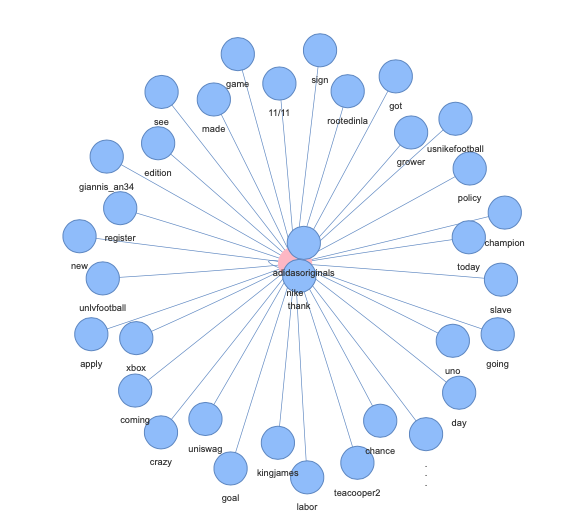

In [56]:
print(nike_words.num_edges())
print(nike_words.num_nodes())
display_graph(nike_words, "common_words_negative_nike")

33 edges in graph.
34 nodes in graph.


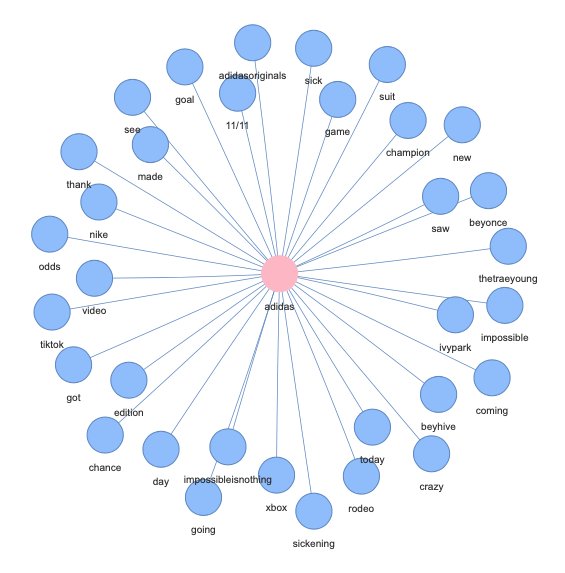

In [57]:

display_graph(adidas_words, "common_words_negative_adidas")


In [58]:
display_graph(lululemon_words, None)

0 edges in graph.
0 nodes in graph.


### Semantic Network Conclusions


#### What Word Clusters Does Each Brand Own?

**In General**

For Nike in general we see words like shoe, undefeated, available, fresh, new, sneaker, pair. In general these words all seem to relate to Nike's top products: shoes. In some cases specific Nike shoe products pop up - like air.
For Adidas we see similar words - indicating information about thier shoes (shoe, pair, store, game, sneaker). Then we see things more specific to Adidas like Yeezy and addidas originals. Lululemon, is not as well known for their shoes, and there are also a lot fewer Lululemon tweets by a large margin. So un general we see words like Womens, store, want. A lot more generic, likely because there are fewer tweets to pull from.


**Positive Sentiment**

Many of the words for positive sentiment end up being the same across all three brands. For example we can see things like good, love, best, favorite across each of the brands. Looking at Nike specifically we can see more brand-specific words related to products like shoes, sneakers as we saw before indicating general positive sentiment around the shoes. Additionally we see things like style and fresh. We see these largely for Nike and Adidas, indicating that people may just think the brand is cool/stylish. Again for Lululemon, there are fewer words and they're still generic, and not really specific to the brand itself, things like favorite, love, women's.


**Negative Sentiment**
Generally speaking, I think negative sentiment was a little harder to work with, as some of the words found still seemed positive. TextBlob isn't perfect so, it's possible the sentiment was incorreclty classified (this could be due to misspellings, sarcasm, and just the messy nature of tweets). I really didn't see too many negative words. Sick and Crazy were used a few times, but sometimes people use that with a positive connotaion, so it's hard to tell for sure. It's also interesting to note that Tik Tok and Video showed up as common words for negative tweets. Possibly indicating video media may yield more negative sentiment for the products. It's also interesting to note that there were no top words used in Lululemon tweets with negative sentiment.


#### Bridging Words?

**In General**

From the above analysis and graphs, we can see that when we look at the clusters of words shared between Nike, Adidas, and Lululemon we see common common words including things like shop, online, want, store, and brand. Generally we see that the bridge words that relate to all three brand are relating to the idea of buying/shopping for an item.

**Positive Sentiment**

When we break it down by the sentiments specifically, we start to see more generic words that commonly describe people's thoughts.
For example some of the general words we see are things like best, favorite, like, etc. Btt when looking at bridge words it may be things more specific to the brands. For example Nike and Adidas often share words like win, play, and together. Since these are commons sporting brands we see more verbiage that could be related to sports.

**Negative Sentiment**

As mentioned above, negative sentiment was harder to work with. Any bridge words would have been those shared by both Nike and Adidas as no top words were found in negative Lululemon tweets. The words I did find as possible bridge words included: Crazy, Chance and New. Again it's hard to get a sense for what these negative sentiments could be with the basic sentiment analysis used. I think we'd need a more in depth analysis to yield stronger insights.